In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import pkg_resources


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

In [2]:
#Needs to be installed on Colab as well
!python -m spacy download en_core_web_lg -q 

     |████████████████████████████████| 587.7 MB 9.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
nlp = spacy.load('en_core_web_lg')

In [4]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [5]:
#Warning suppression
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [6]:
#Nothing wrangles data quite like some functions

def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

In [7]:
#Knowledge Context Graph Functions

def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

In [8]:
# Entity Extraction Functions
# More useful info found here:
# https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

In [9]:
#Visualization Utility Functions

def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [10]:
#Phew! After all that, we're ready to read in our dataset!

CORPUS_PATH = 'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/ClassCorpus_Final_v5_20220717.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

# From our experience with assingment 2, let's jettison the nonstandard characters right away
corpus_df['Text'] = corpus_df['Text'].apply(lambda x: ''.join([i if 32 < ord(i) < 126 else " " for i in x]))

# And let's tokenize the sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,40,41,42
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,Who ARE all these people? That was what I ...,Ric Roman Waugh s Angel Has Fallen sees U.S. S...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Student Name,KCM,KCM,KCM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42
Doc_ID,40,41,42
raw_sentences,[Boredom sets in long before the start of Ange...,"[ Who ARE all these people? , That was what...",[Ric Roman Waugh s Angel Has Fallen sees U.S. ...


In [11]:
#Let's get granular! Tokenize words engage. Plus, let's define some stopwords.

default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
40    [boredom, set, long, start, angel, fallen, sta...
41    [people, mutter, enter, screening, angel, fall...
42    [ric, roman, waugh, angel, fallen, secret, ser...
43    [certain, mindless, pleasure, fallen, movie, w...
44    [need, olympus, fallen, andor, london, fallen,...
Name: lemmas, dtype: object

In [12]:
# Lemmatized words... assemble!

corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.head(3).T

Doc_ID,40,41,42
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,Who ARE all these people? That was what I ...,Ric Roman Waugh s Angel Has Fallen sees U.S. S...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Student Name,KCM,KCM,KCM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42
Doc_ID,40,41,42
raw_sentences,[Boredom sets in long before the start of Ange...,"[ Who ARE all these people? , That was what...",[Ric Roman Waugh s Angel Has Fallen sees U.S. ...


In [13]:
#Vocabulary data wrangling

vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

# Research opportunity: ignore terms that aren't within these frequencies... change the frequencies
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 11765
Curated Vocabulary size: 2884


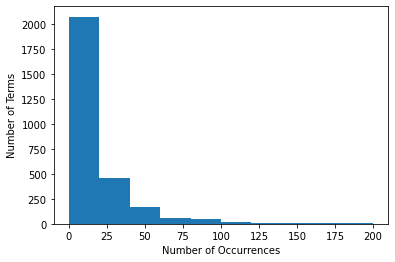

In [14]:
#Let's take a look at this in bar graph form

plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [15]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

# And get the lemmatized and filtered sentences
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

corpus_df.head().T

Doc_ID,40,41,42,43,44
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,Who ARE all these people? That was what I ...,Ric Roman Waugh s Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...,"No, you don t need to have seen Olympus Has F..."
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43,Action_Angel Has Fallen_N_44
Doc_ID,40,41,42,43,44
raw_sentences,[Boredom sets in long before the start of Ange...,"[ Who ARE all these people? , That was what...",[Ric Roman Waugh s Angel Has Fallen sees U.S. ...,[There is a certain mindless pleasure in the F...,"[No, you don t need to have seen Olympus Has ..."


In [16]:
# Let's double check the unique movie titles
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No Time To Die' 'Taken' 'Taxi'
 'Despicable Me 3' 'Dirty Grandpa' 'Holmes and Watson' 'Legally Blonde'
 'The Lost City' 'Drag me to hell' 'Fresh' 'It Chapter Two'
 'The Toxic Avenger' 'US' 'Batman' 'Equilibrium' 'Minority Report'
 'Oblivion' 'Pitch Black']


In [17]:
# Make a copy of the dataframe for a single movie title. Let's use my contribution, Pitch Black.
movie_df = corpus_df[corpus_df['Movie Title'] == 'Pitch Black'].copy()
movie_df.head(3).T

Doc_ID,191,192,196
DSI_Title,JSA_Doc2_PitchBlack,JSA_Doc3_PitchBlack,JSA_Doc7_PitchBlack
Text,No other movie opening thrills me more than a ...,"It's sci-fi season once again, what with this ...",There are just no good aliens anymore. The tit...
Submission File Name,JSA_Doc2_PitchBlack,JSA_Doc3_PitchBlack,JSA_Doc7_PitchBlack
Student Name,Jeremy Savill,Jeremy Savill,Jeremy Savill
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Pitch Black,Pitch Black,Pitch Black
Descriptor,Sci-Fi_Pitch Black_N_191,Sci-Fi_Pitch Black_N_192,Sci-Fi_Pitch Black_N_196
Doc_ID,191,192,196
raw_sentences,[No other movie opening thrills me more than a...,"[It's sci-fi season once again, what with this...","[There are just no good aliens anymore., The t..."


In [18]:
#Lines of code to look at both raw sentences and lemmatized sentences.

#corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
corpus_text_sentences = [y for x in movie_df.sentences_lemmatized for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'hope strange amazing adventure'

In [19]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]
entity_pairs

100%|██████████| 367/367 [00:02<00:00, 145.74it/s]


[['', 'thrill ship space'],
 ['visual rule kubrick', 'detailed  model'],
 ['space star wars', ''],
 ['ago day space robert', 'master eric frank'],
 ['state mind capture', 'good title history magazine'],
 ['', 'amazing  adventure'],
 ['', ''],
 ['', ''],
 ['deep end desert planet', 'good science fiction'],
 ['away  earth', 'tired  generic'],
 ['', 'dangerous prisoner sleep'],
 ['', ''],
 ['fry radha mitchell', 'command'],
 ['star system sun', 'vicious riddick vin diesel'],
 ['', 'private  ryan'],
 ['', ''],
 ['', ''],
 ['', 'fellow feeling consider'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', 'human  conflict'],
 ['human land world', 'quickly rock play game'],
 ['', ''],
 ['story element', 'aside  plan'],
 ['', ''],
 ['complex space trajectory', 'difficult life form'],
 ['', ''],
 ['thing', 'dark  planet'],
 ['kind  question', 'black answer minute'],
 ['story', 'sure diesel character specie'],
 ['', ''],
 ['', 'necessary end wonder plot'],
 ['twohy step arrival', 'warm earth comfort zone']

In [20]:
#Creates the dataframe for the source, target, and edge properties of the knowledge graph

relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [21]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

kg_df.tail(6).T

,351,353,355,357,360,365
source,fi world look,special effect,character,limited keith role,menacing charisma aspect,alien rip
target,alien landscape,twist drive story,interesting aspect,moral center,fascinating lead,class style heart
edge,evoke alien,rely,cut interesting,turn muslim,create fascinating,rip


In [22]:
len(corpus_text_sentences)

367

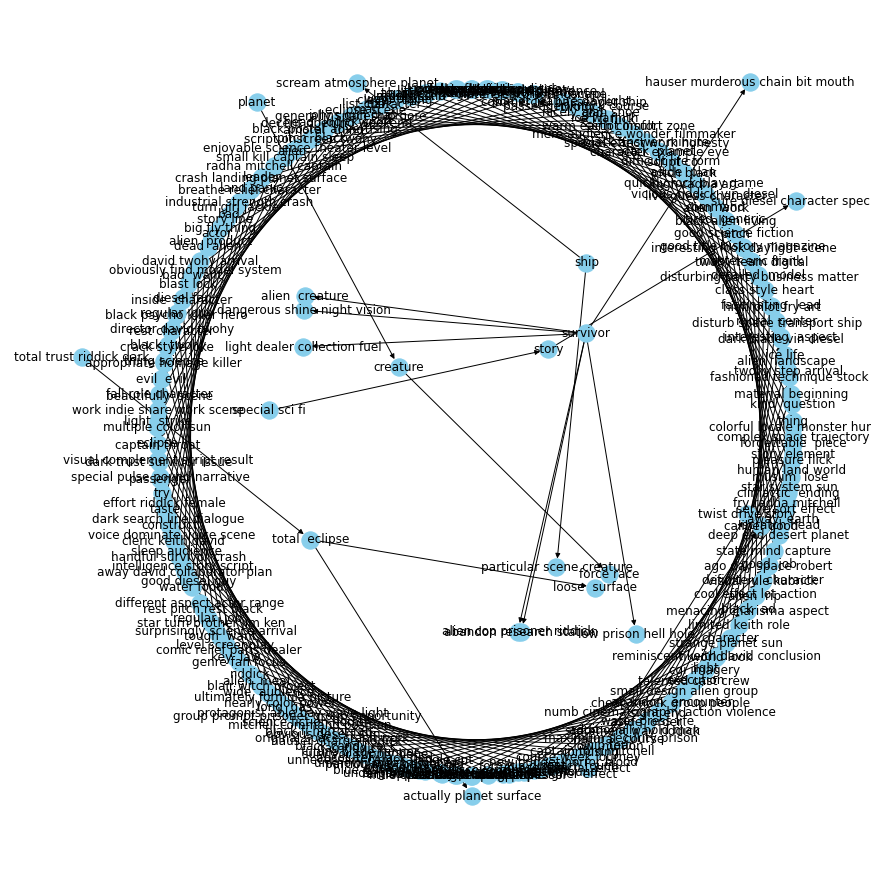

In [23]:
# Let's visualize ourselves a fancy knowledge graph

plot_graph(kg_df, use_circular=False)

In [24]:
#Let's take a look at the top sources and targets for the lemmatized sentences

get_top_sources_and_targets(kg_df, 20)

[('survivor', 7),
 ('total  eclipse', 3),
 ('story', 2),
 ('ship', 2),
 ('creature', 2),
 ('special  effect', 2),
 ('visual rule kubrick', 1),
 ('ago day space robert', 1),
 ('state mind capture', 1),
 ('deep end desert planet', 1),
 ('away  earth', 1),
 ('fry radha mitchell', 1),
 ('star system sun', 1),
 ('human land world', 1),
 ('story element', 1),
 ('complex space trajectory', 1),
 ('thing', 1),
 ('kind  question', 1),
 ('twohy step arrival', 1),
 ('ice life', 1)]

In [25]:
#Can't forget about the edges

get_top_edges(kg_df, 20)

[('include', 5),
 ('find', 4),
 ('bring', 3),
 ('pose', 2),
 ('fear', 2),
 ('manage', 2),
 ('speak', 2),
 ('discover', 2),
 ('think', 2),
 ('start', 2),
 ('hit', 2),
 ('enjoy', 2),
 ('use detailed', 1),
 ('forget', 1),
 ('doubt good', 1),
 ('begin deep', 1),
 ('find tired', 1),
 ('assume', 1),
 ('set survive', 1),
 ('feel human', 1)]

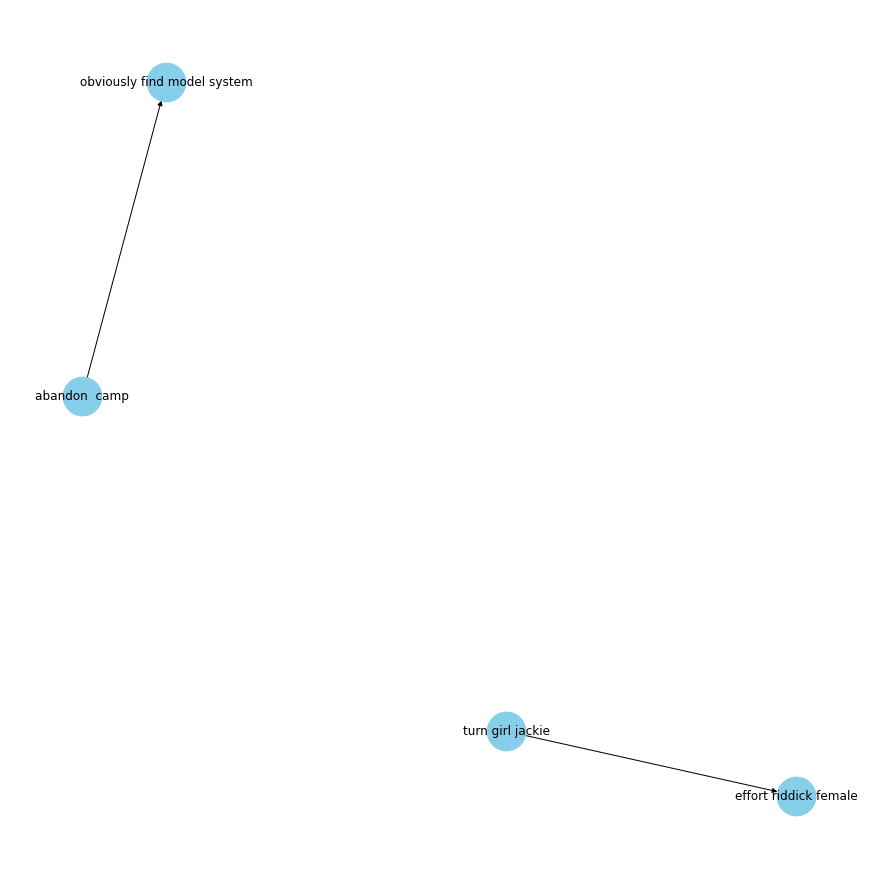

In [26]:
# input relationship in edge== to see a smaller graph
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="discover"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [27]:
# Let's narrow down the source/targets to the top few words

survivordf = kg_df[kg_df['source']=="survivor"]
tedf = kg_df[kg_df['source']=="total eclipse"]
storydf = kg_df[kg_df['source']=="story"]
shipdf = kg_df[kg_df['source'] =="ship"]
creaturedf = kg_df[kg_df['source'] =="creature"]
sfxdf = kg_df[kg_df['source'] == "special effect"]


In [28]:
sourcedf = survivordf.append(tedf).append(storydf).append(shipdf).append(creaturedf).append(sfxdf)
sourcedf

,source,target,edge
49,survivor,hauser murderous chain bit mouth,include
147,survivor,alien creature,hit
149,survivor,dangerous shine night vision,include dangerous
156,survivor,light dealer collection fuel,include
272,survivor,alien cop prisoner riddick,include
274,survivor,abandon research station,discover abandon
340,survivor,low prison hell hole,find
30,story,sure diesel character specie,pose
99,ship,scream atmosphere planet,find
303,ship,particular scene creature,crash excellent


In [29]:
nx.get_edge_attributes(G,'edge')

{('abandon  camp', 'obviously find model system', 0): 'discover',
 ('turn girl jackie', 'effort riddick female', 0): 'discover'}

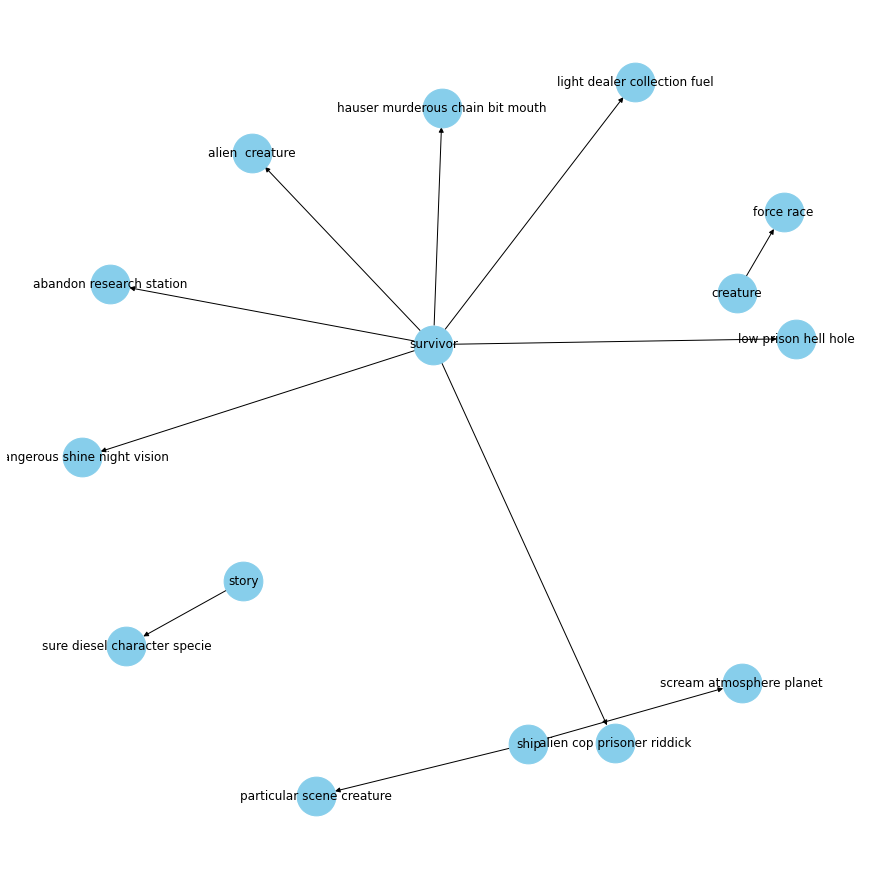

In [30]:
# input relationship in edge== to see a smaller graph
G=nx.from_pandas_edgelist(sourcedf, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.4) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
#nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'edge'))
plt.show()

In [31]:
# Whoa, that's kinda messy... Maybe this will make sense when we develop the RNN model

datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

,0,1,2,3,4
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,Who ARE all these people? That was what I ...,Ric Roman Waugh s Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...,"No, you don t need to have seen Olympus Has F..."
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43,Action_Angel Has Fallen_N_44
Doc_ID,40,41,42,43,44
raw_sentences,[Boredom sets in long before the start of Ange...,"[ Who ARE all these people? , That was what...",[Ric Roman Waugh s Angel Has Fallen sees U.S. ...,[There is a certain mindless pleasure in the F...,"[No, you don t need to have seen Olympus Has ..."


In [32]:
#Let's do a little data preprocessing.

datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

data = datafull[['Text','Genre of Movie']].copy()

data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

In [33]:
features, targets = data['Text'], data['Genre of Movie code']
 
train_features, test_features, train_targets, test_targets = train_test_split(features
                                                                              ,targets
                                                                              ,test_size=0.20
                                                                              ,random_state=42
                                                                              ,shuffle = True
                                                                              ,stratify=targets)
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      50
Comedy          1                      50
Horror          2                      50
Sci-Fi          3                      50
dtype: int64

In [34]:
# Let's create the training and testing datasets

trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

In [35]:
#And convert from dataframe to Tensorflow dataset

# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

#Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

# Create Data Pipelines (Batching, Shuffling, and Optimizing)

batch_size = 4 #Research change parameter from 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 200 non-null    object  
 1   Genre of Movie       200 non-null    category
 2   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.3+ KB


**Create the Text Encoder**

The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the experimental.preprocessing.TextVectorization layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's .adapt method: The processing of each sample contains the following steps:

standardize each sample (usually lowercasing + punctuation stripping)
split each sample into substrings (usually words)
recombine substrings into tokens (usually ngrams)
index tokens (associate a unique int value with each token)
transform each sample using this index, either into a vector of ints or a dense float vector.

In [317]:
# For more information: tf.keras.layers.TextVectorization
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

VOCAB_SIZE= 5000 # Research experiment to see if adjusting vocab size can improve the model
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [37]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'i', 'movie', 'one', 'it', 'like',
       'time', 'get', 'make', 'nt', 'character', 'even', 'but', 'scene',
       'much', 'way'], dtype='<U13')

In [38]:
vocab[-20:]

array(['mouth', 'meant', 'meaning', 'liberty', 'legacy', 'leading',
       'killed', 'kick', 'jennings', 'immediately', 'hot', 'guess', 'god',
       'goal', 'fry', 'from', 'freedom', 'flashback', 'finding',
       'fighting'], dtype='<U13')

In [39]:
# Example of encoded words
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([  1, 153,   1, 840,   1,   1, 116, 116])

In [40]:
encoder(data['Text'][0])

<tf.Tensor: shape=(500,), dtype=int64, numpy=
array([  1,  54,  82, 109, 294, 230, 196,   5, 109,   1,   6,   1,  42,
         1,  56,   1, 216,  56, 664,   9,   1,   1,   1,   1, 218,   1,
         1,   1,   1,   5, 677,   1,   1, 365,   1,   1, 611,   5,  69,
        56, 756,   1,   9,  55,  20,   6,   1, 105,   1, 105,  69,   1,
       105, 204, 105,   1,   8, 517,   7, 473, 976,   1, 108,   1,  99,
         1,   1,  96,  37,   1, 239, 294, 230, 196, 635, 459,  33,  37,
         1,  26, 307,   6,  80,   1, 625,  37,   1, 242,  83,   1,  26,
         1, 394, 415,   1, 289, 195,  33, 274,   1,   1, 159, 517, 596,
         1,   1, 108, 184, 596, 770, 737,  95,   1,   1, 359,   5,  61,
       485, 897,   1,   1,   5, 283, 484, 274, 204,   5,   1,   1,   1,
         1,  27,  39,   1,   1,   1,   1, 299,   1,   1,   5,   1,   5,
        27,   1,   1, 307,   1,   5,  65,  21,  35, 610, 655, 527, 557,
       294, 230, 196, 802, 349, 257,   1,   1, 527,   1,   1,   1,   1,
         1,   1,  

In [41]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'My hope high Dirty Grandpa , simply mere existence made practical sense . A movie starring Robert De Niro Zac Efron sound like real movie . It sound like fake movie see clip film mocking stupidity Hollywood . For intent purpose , Dirty Grandpa exist form one fake trailer open Tropic Thunder . And yet , . All 102 minute . Before watching , mind raced stupid possibility . How many Viagra joke would ? Would somebody ask De Niro Viagra induced boner De Niro respond , Are talking ? shortly one grip run onto set give high five ? Would scene dog win farting contest fart hard launch inside bare , gaping as competitor : cameo Harvey Keitel ( , implied , accidentally overdosed Viagra ) ? Unfortunately , moment outside Pinterest page and/or dream board . But luckily , got equally stupid . Maybe even little . As may already guessed , Dirty Grandpa terrible derivative title implies . But Dirty Grandpa also kind terrible I embrace appreciate . It bad way might intentional . Ten minute fil

In [70]:
# Building the RNN sequential model

num_classes=4 # Changed from 5 as we only have 4 genres
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24,dropout=0.3))
   ,tf.keras.layers.Dense(32, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 32)          32000     
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 64)         16640     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 48)               17088     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                1568      
                                                      

In [72]:
# Compiling the model

model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [73]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
40/40 [==============================] - 26s 216ms/step - loss: 1.3891 - accuracy: 0.2188 - val_loss: 1.3888 - val_accuracy: 0.2500
Epoch 2/200
40/40 [==============================] - 3s 88ms/step - loss: 1.3786 - accuracy: 0.2812 - val_loss: 1.3811 - val_accuracy: 0.3333
Epoch 3/200
40/40 [==============================] - 3s 86ms/step - loss: 1.3640 - accuracy: 0.4062 - val_loss: 1.4905 - val_accuracy: 0.1667
Epoch 4/200
40/40 [==============================] - 3s 87ms/step - loss: 1.3372 - accuracy: 0.4000 - val_loss: 1.1931 - val_accuracy: 0.4167
Epoch 5/200
40/40 [==============================] - 3s 88ms/step - loss: 0.9933 - accuracy: 0.5688 - val_loss: 1.3622 - val_accuracy: 0.3333
Epoch 6/200
40/40 [==============================] - 3s 86ms/step - loss: 0.7685 - accuracy: 0.6687 - val_loss: 1.3126 - val_accuracy: 0.5000
Epoch 7/200
40/40 [==============================] - 3s 87ms/step - loss: 0.5475 - accuracy: 0.7688 - val_loss: 1.3926 - val_accuracy: 0.5000
Epoc

In [74]:
# So, uh, how'd we do?

test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

5/5 [==============================] - 0s 46ms/step - loss: 0.9644 - accuracy: 0.5500
Test Loss: 0.9644191861152649
Test Accuracy: 0.550000011920929


In [47]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [75]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
4,0.690,0.719,0.851,0.750
5,0.444,0.856,0.762,0.667
6,0.240,0.925,0.337,0.917
7,0.093,0.981,1.389,0.583
8,0.051,0.981,0.236,0.917


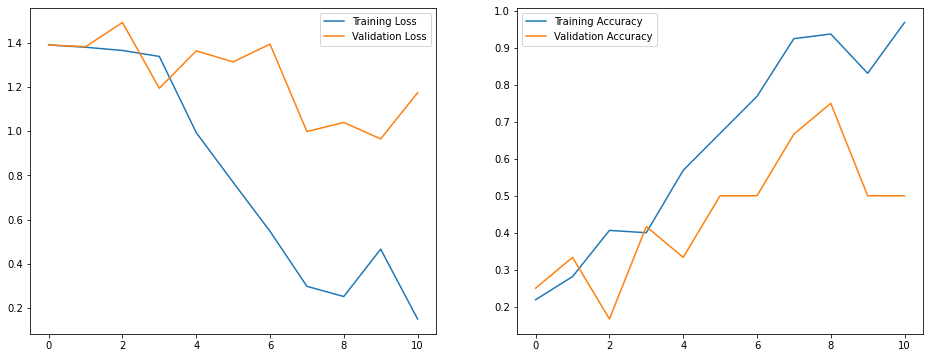

In [76]:
# Let's plot it

losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

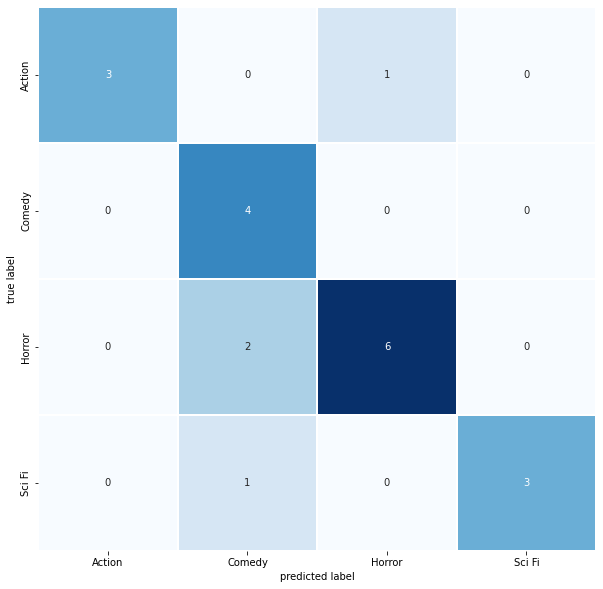

In [69]:
# And now for the confusion matrix

preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [51]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,0.04%,0.05%,1.31%,0.86%,0.34%,0.15%,0.03%,0.33%,1.49%,95.24%,1.23%,0.82%,0.53%,0.12%,0.03%
Comedy,98.92%,95.71%,0.44%,0.58%,20.04%,95.71%,98.59%,88.09%,0.97%,0.09%,0.25%,2.12%,87.80%,1.54%,99.06%
Horror,0.60%,1.76%,98.23%,98.52%,6.59%,3.40%,0.66%,7.94%,96.96%,4.66%,98.50%,96.86%,11.13%,1.40%,0.50%
Sci Fi,0.44%,2.48%,0.02%,0.04%,73.04%,0.74%,0.72%,3.65%,0.57%,0.01%,0.02%,0.21%,0.54%,96.95%,0.40%


In [318]:
#Sentiment Model Time

sentiment_data = datafull[['Review Type (pos or neg)', 'Text']]

sentiment_data['Review Type (pos or neg)'] = sentiment_data['Review Type (pos or neg)'].str.lower()

sentiment_data['Review Type (pos or neg)'] = sentiment_data['Review Type (pos or neg)'].astype("category")
sentiment_data['sentiment_code'] = sentiment_data['Review Type (pos or neg)'].cat.codes
sentiment_data.head()

,Review Type (pos or neg),Text,sentiment_code
0,negative,Boredom set long start Angel Has Fallen . I st...,0
1,negative,Who ARE people ? That I muttered I entered fir...,0
2,negative,Ric Roman Waugh Angel Has Fallen see U.S. Secr...,0
3,negative,There certain mindless pleasure Fallen movie ....,0
4,negative,"No , need seen Olympus Has Fallen and/or Londo...",0


In [319]:

sfeatures, stargets = sentiment_data['Text'], sentiment_data['sentiment_code']


strain_features, stest_features, strain_targets, stest_targets = train_test_split(sfeatures, 
                                                                              stargets , 
                                                                              test_size=0.20, 
                                                                              random_state=42, 
                                                                              shuffle=True,
                                                                              stratify=stargets)


strainds, svalds, stestds = get_dataset_partitions_pd(sentiment_data[['Text','sentiment_code']])
strainds.shape, svalds.shape, stestds.shape

((160, 2), (20, 2), (20, 2))

In [320]:
# train X & y
strain_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(strainds['Text'].values, tf.string)
) 
strain_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(strainds['sentiment_code'].values, tf.int64),
  ) 
# test X & y
stest_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(stestds['Text'].values, tf.string)
) 
stest_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(stestds['sentiment_code'].values, tf.int64),
)
#val X & Y
sval_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(svalds['Text'].values, tf.string)
) 
sval_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(svalds['sentiment_code'].values, tf.int64),
)

strain_ds = tf.data.Dataset.zip(
    (
            strain_text_ds_raw,
            strain_cat_ds_raw
     )
)
stest_ds = tf.data.Dataset.zip(
    (
            stest_text_ds_raw,
            stest_cat_ds_raw
     )
)
sval_ds = tf.data.Dataset.zip(
    (
            sval_text_ds_raw,
            sval_cat_ds_raw
     )
)

In [321]:
batch_size = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE
sbuffer_size = strain_ds.cardinality().numpy()

strain_ds = (strain_ds.shuffle(buffer_size=sbuffer_size)
                    .batch(batch_size=batch_size,drop_remainder=True)
                    .cache()
                    .prefetch(AUTOTUNE))

stest_ds = (stest_ds.shuffle(buffer_size=sbuffer_size)
                  .batch(batch_size=batch_size,drop_remainder=True)
                  .cache()
                  .prefetch(AUTOTUNE))

sval_ds = (sval_ds.shuffle(buffer_size=sbuffer_size)
                .batch(batch_size=batch_size,drop_remainder=True)
                .cache()
                .prefetch(AUTOTUNE))

In [322]:
sx_train = strain_features.to_numpy()
sy_train = strain_targets.to_numpy()
sx_test = stest_features.to_numpy()
sy_test = stest_targets.to_numpy()

In [359]:
num_classes=2 # postive or negative
sent_model_1 = tf.keras.Sequential([sencoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.3)),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

In [360]:
sent_model_1.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_9 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_31 (Embedding)    (None, None, 128)         640000    
                                                                 
 bidirectional_62 (Bidirecti  (None, None, 256)        263168    
 onal)                                                           
                                                                 
 bidirectional_63 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_62 (Dense)            (None, 128)               32896     
                                                     

In [361]:
sent_model_1.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [362]:
#%%time
shistory = sent_model_1.fit(strain_ds
         ,epochs=20
         ,validation_data=sval_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)])

Epoch 1/20
40/40 [==============================] - 29s 270ms/step - loss: 0.6975 - binary_accuracy: 0.4250 - val_loss: 0.6936 - val_binary_accuracy: 0.4167
Epoch 2/20
40/40 [==============================] - 5s 134ms/step - loss: 0.6119 - binary_accuracy: 0.7250 - val_loss: 0.6993 - val_binary_accuracy: 0.5833
Epoch 3/20
40/40 [==============================] - 5s 135ms/step - loss: 0.5769 - binary_accuracy: 0.7625 - val_loss: 2.8859 - val_binary_accuracy: 0.3333
Epoch 4/20
40/40 [==============================] - 5s 136ms/step - loss: 0.2570 - binary_accuracy: 0.9250 - val_loss: 0.9566 - val_binary_accuracy: 0.5000
Epoch 5/20
40/40 [==============================] - 5s 135ms/step - loss: 0.1987 - binary_accuracy: 0.9438 - val_loss: 0.9159 - val_binary_accuracy: 0.7500
Epoch 6/20
40/40 [==============================] - 5s 133ms/step - loss: 0.0405 - binary_accuracy: 0.9875 - val_loss: 0.9292 - val_binary_accuracy: 0.7500
Epoch 7/20
40/40 [==============================] - 5s 135ms/st

In [363]:
test_loss, test_acc = sent_model_1.evaluate(sval_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

5/5 [==============================] - 0s 49ms/step - loss: 2.0323 - binary_accuracy: 0.6500
Test Loss: 2.032254219055176
Test Accuracy: 0.6499999761581421


In [364]:
shistory_dict = shistory.history
shistory_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [365]:
shistory_df=pd.DataFrame(shistory_dict)
shistory_df.tail().round(3)

,loss,binary_accuracy,val_loss,val_binary_accuracy
5,0.040,0.988,0.929,0.750
6,0.003,1.000,0.989,0.833
7,0.002,1.000,1.056,0.833
8,0.001,1.000,1.110,0.833
9,0.001,1.000,1.155,0.833


In [366]:
losses = shistory.history['loss']
accs = shistory.history['binary_accuracy']
val_losses = shistory.history['val_loss']
val_accs = shistory.history['val_binary_accuracy']
epochs = len(losses)

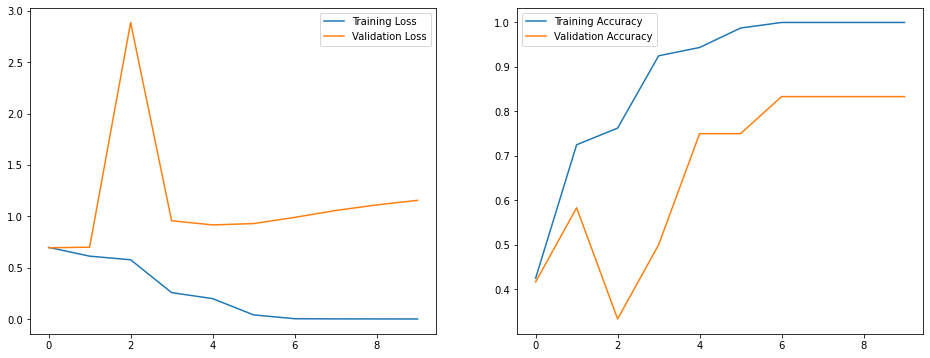

In [367]:
epochs = len(losses)
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [368]:
spreds = sent_model_1.predict(stest_ds)
sy_pred = (spreds > 0.5).astype("int32")
sy_1 = np.concatenate([y for x, y in stest_ds], axis=0)

In [369]:
CLASS_LIST = ['Positive','Negative']

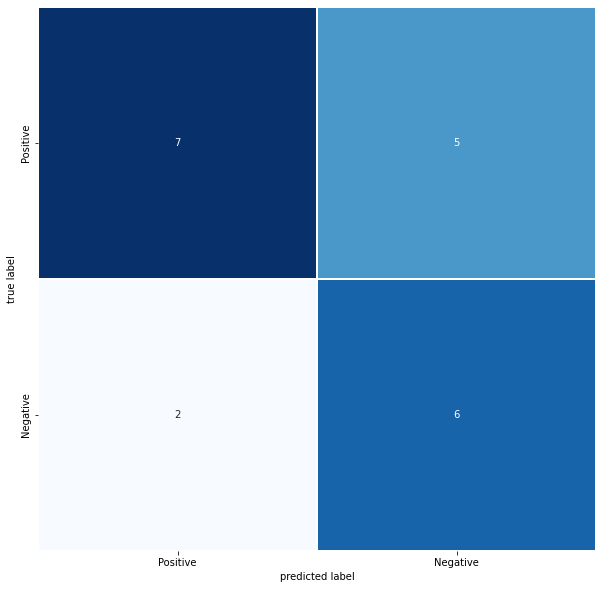

In [370]:
plot_confusion_matrix_labeled(sy_1, sy_pred, CLASSES_LIST=CLASS_LIST)